In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')

GPU device: 0


### Data Preparation

In [3]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [4]:
train_keys = [
    "ane",
    "ate",
    "autor",
    "machtor",
    "x",
    "zeff",
    "gammae",
    "q",
    "smag",
    "alpha",
    "ani1",
    "ati0",
    "normni1",
    "ti_te0",
    "lognustar",
]

target_keys = ['target']

In [5]:
x_train, y_train = train_data[train_keys].to_numpy(), train_data[target_keys].to_numpy()

x_val, y_val = validation_data[train_keys].to_numpy(), validation_data[target_keys].to_numpy()

In [6]:
# standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

### Classifier functions

In [7]:
class Classifier(nn.Module):
    def __init__(self, inshape): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(inshape, 30), 
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(30, 30), 
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Dropout(p=0.1), 
            nn.Linear(30,1)
        )
        
    def forward(self, x): 
        output = self.model(x)
        
        return output

In [8]:
class ClassifierData(Dataset): 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [9]:
train_set = ClassifierData(x_train, y_train)
valid_set = ClassifierData(x_val, y_val)
train_loader = DataLoader(train_set, batch_size = 1024, shuffle = True)
val_loader = DataLoader(valid_set, batch_size = 1024, shuffle = True)

In [14]:
def train_loop(model, optimiser, epochs, traindata, validdata=None): 
    history = {'epoch_loss': [], 'epoch_val_loss': []}
    
    for epoch in tqdm(range(epochs), desc = 'Epochs'):
        
        running_loss = []
        
        for i, data in enumerate(tqdm(traindata, 0)): 
            x, y = data
            x, y = x.to(device), y.to(device)
            
            
            # zero the parameter gradients
            optimiser.zero_grad()

            #forward + backward + optimize
            y_hat = model(x.float())
            activation = nn.Sigmoid()
            BCE = nn.BCELoss()
            loss = BCE(activation(y_hat.float()), y.float())
            loss.backward()
            optimiser.step()
            
            # print statistics
            running_loss.append(loss.item())
            if i % 1000 == 0:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {np.mean(running_loss) :.6f}')
        
        history['epoch_loss'].append(np.mean(running_loss))
    return history

In [15]:
classifier = Classifier(x_train.shape[1]).to(device)

In [16]:
optimiser = optim.Adam(classifier.parameters(), lr=0.001)

In [17]:
his = train_loop(model=classifier, optimiser=optimiser, epochs=1, traindata=train_loader)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/26090 [00:00<?, ?it/s]

[1,     1] loss: 0.681695
[1,  1001] loss: 0.523398
[1,  2001] loss: 0.486126
[1,  3001] loss: 0.463563
[1,  4001] loss: 0.449449
[1,  5001] loss: 0.439585
[1,  6001] loss: 0.432564
[1,  7001] loss: 0.427136
[1,  8001] loss: 0.422867
[1,  9001] loss: 0.419337
[1, 10001] loss: 0.416431
[1, 11001] loss: 0.413883
[1, 12001] loss: 0.411775
[1, 13001] loss: 0.409767
[1, 14001] loss: 0.408025
[1, 15001] loss: 0.406469
[1, 16001] loss: 0.405021
[1, 17001] loss: 0.403768
[1, 18001] loss: 0.402634
[1, 19001] loss: 0.401516
[1, 20001] loss: 0.400547
[1, 21001] loss: 0.399670
[1, 22001] loss: 0.398846
[1, 23001] loss: 0.398085
[1, 24001] loss: 0.397356
[1, 25001] loss: 0.396695
[1, 26001] loss: 0.396030


In [18]:
t_vals = []

In [19]:
def T_scaling(logits, temperature):
    t_vals.append(temperature.item())
    output = torch.div(logits, temperature)
    activation = nn.Sigmoid()
    return activation(output)

In [20]:
temp = nn.Parameter((1.5*torch.ones(1)).cuda())
criterion = nn.BCELoss()
# optimizer = optim.LBFGS([temp], lr=0.01, max_iter=50, line_search_fn='strong_wolfe')
optimizer = optim.LBFGS([temp], lr=0.01, max_iter=100, line_search_fn='strong_wolfe')
logits_list = []
labels_list = []

for i, data in enumerate(tqdm(val_loader, 0)):
    x, y = data[0].to(device), data[1].to(device)
    
    classifier.eval()
    with torch.no_grad():
        logits_list.append(classifier(x.float()))
        labels_list.append(y.float())

# Create tensors
logits_list = torch.cat(logits_list).to(device)
labels_list = torch.cat(labels_list).to(device)

def _eval():
    loss = criterion(T_scaling(logits_list, temp), labels_list)
    loss.backward()
    return loss

optimizer.step(_eval)

  0%|          | 0/3262 [00:00<?, ?it/s]

tensor(0.3808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

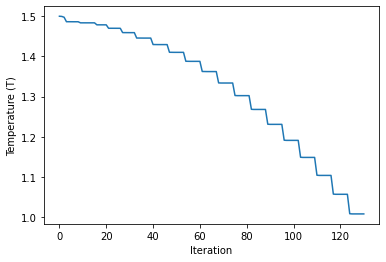

In [24]:
plt.figure()
plt.plot(t_vals)
plt.xlabel('Iteration')
plt.ylabel('Temperature (T)');